In [ ]:
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import glob, os, random

In [ ]:
!mkdir dataset
!cd dataset && unzip ../drive/Shareddrives/B21-CAP0331/dataset/dataset-2/dataset-v2.zip
PATH_DATASET = 'dataset/'

mkdir: cannot create directory ‘dataset’: File exists
Archive:  ../drive/Shareddrives/B21-CAP0331/dataset/dataset-2/dataset-v2.zip
replace cardboard/cardboard1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
classes = ["cardboard", "glass", "metal", "paper", "plastic"]

counts = []
for class_ in classes:
  folderPath = PATH_DATASET + class_
  count = len([name for name in os.listdir(folderPath) if os.path.isfile(os.path.join(folderPath, name))])
  counts.append(count)
  print(class_, count)

cardboard 403
glass 501
metal 410
paper 594
plastic 482


<BarContainer object of 5 artists>

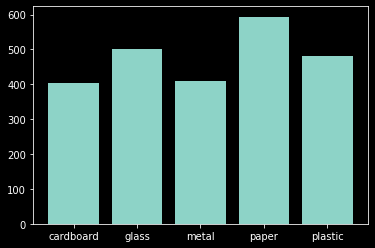

In [ ]:
plt.style.use('dark_background')
plt.bar(classes, counts)

In [ ]:
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET
    )

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET,
    validation_split=0.2,
    subset='training',
    seed=0
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_DATASET,
    validation_split=0.2,
    subset='validation',
    seed=0
)

Found 2390 files belonging to 5 classes.
Found 2390 files belonging to 5 classes.
Using 1912 files for training.
Found 2390 files belonging to 5 classes.
Using 478 files for validation.


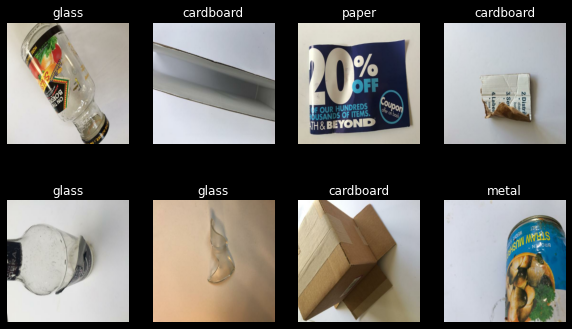

In [ ]:
# train
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

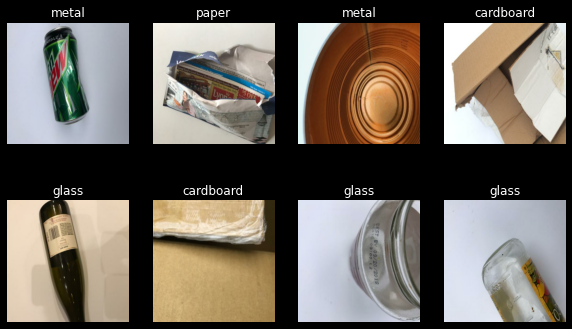

In [ ]:
# validation
plt.figure(figsize=(10, 6))
for images, labels in validation_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [ ]:
# inspect shape
train_batch = train_ds.as_numpy_iterator().next()

print('Total batches:', len(train_ds))
print('Images batch shape:', train_batch[0].shape)
print('Labels batch shape:', train_batch[1].shape)

Total batches: 60
Images batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


In [ ]:
IMG_SHAPE = (256, 256,3)
BASE_MODEL = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

In [ ]:
# fine-tuning
BASE_MODEL.trainable = True

In [ ]:
BASE_MODEL.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = BASE_MODEL.get_layer(tuning_layer_name)
tuning_index = BASE_MODEL.layers.index(tuning_layer)

for layer in BASE_MODEL.layers[:tuning_index]:
    layer.trainable =  False

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    
], name='data_augmentation')

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    BASE_MODEL,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

learning_rate = 0.00001
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50
)

Epoch 1/50
60/60 [==============================] - 42s 542ms/step - loss: 1.5433 - accuracy: 0.3311 - val_loss: 1.2181 - val_accuracy: 0.5209
Epoch 2/50
60/60 [==============================] - 28s 462ms/step - loss: 1.0583 - accuracy: 0.6297 - val_loss: 0.8802 - val_accuracy: 0.6695
Epoch 3/50
60/60 [==============================] - 28s 458ms/step - loss: 0.8078 - accuracy: 0.7291 - val_loss: 0.7042 - val_accuracy: 0.7469
Epoch 4/50
60/60 [==============================] - 28s 459ms/step - loss: 0.6818 - accuracy: 0.7720 - val_loss: 0.6060 - val_accuracy: 0.7971
Epoch 5/50
60/60 [==============================] - 28s 457ms/step - loss: 0.5830 - accuracy: 0.8101 - val_loss: 0.5390 - val_accuracy: 0.8138
Epoch 6/50
60/60 [==============================] - 28s 458ms/step - loss: 0.4998 - accuracy: 0.8421 - val_loss: 0.4960 - val_accuracy: 0.8410
Epoch 7/50
60/60 [==============================] - 28s 458ms/step - loss: 0.4646 - accuracy: 0.8536 - val_loss: 0.4646 - val_accuracy: 0.8431

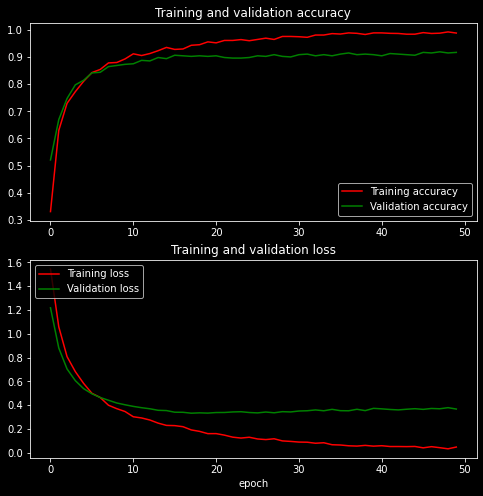

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

In [ ]:
from datetime import datetime
import pickle

def save_model(model, history, modelComment):
  modelDate = datetime.now().strftime("%Y-%m-%d_%H-%M") + "_" + modelComment
  savePath = "drive/Shareddrives/B21-CAP0331/models/" + modelDate
  !mkdir "$savePath"
  tf.keras.models.save_model(model, savePath)
  with open(savePath + "/history.pickle", "wb") as f:
    pickle.dump(history.history, f)
  print("Model saved to ", savePath)
  print("Model name : ", modelDate)
  drive.flush_and_unmount()
  print("Drive flushed out")
  drive.mount("drive")

In [ ]:
save_model(model, history, "model-build-v4_resnet50v2_50epochs")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/Shareddrives/B21-CAP0331/models/2021-05-25_18-19_model-build-v4_resnet50v2_50epochs/assets
Model saved to  drive/Shareddrives/B21-CAP0331/models/2021-05-25_18-19_model-build-v4_resnet50v2_50epochs
Model name :  2021-05-25_18-19_model-build-v4_resnet50v2_50epochs
Drive flushed out
Mounted at drive


In [ ]:
def load_model(modelName):
  loadPath = "drive/Shareddrives/B21-CAP0331/models/" + modelName
  return tf.keras.models.load_model(loadPath)

In [ ]:
model = load_model("2021-05-21_14-52_model-build-v3_resnet50v2_fine-tune_50epochs")

In [ ]:
# list_labels = train_ds.class_names
list_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
print(list_labels)

labels = '\n'.join(list_labels)
with open('labels.txt', 'w') as f:
  f.write(labels)

path = 'labels.txt'
label = np.array(open(path).read().splitlines())
print(label)

['cardboard', 'glass', 'metal', 'paper', 'plastic']
['cardboard' 'glass' 'metal' 'paper' 'plastic']


In [ ]:
wrong = []

i = 0
for cls in list_labels:
  path = PATH_DATASET + cls + '/'
  miss = 0
  count = 0
  for files in os.listdir(path):
    img_path = path + files
    img = image.load_img(img_path, target_size=(256, 256))
    img = image.img_to_array(img, dtype=np.uint8)
    p = model.predict(img[np.newaxis, ...])
    idx = np.argmax(p[0], axis=-1)
    if (idx != i):
      miss += 1
      wrong.append(cls + '/' + files)
    count += 1
  i += 1
  print (cls)
  print('count', count)
  print('miss', miss)
  print('acc {}%'.format(round((1 - (miss / count)) * 100, 2) ))
  print ('-----')

cardboard
count 403
miss 6
acc 98.51%
-----
glass
count 501
miss 15
acc 97.01%
-----
metal
count 410
miss 8
acc 98.05%
-----
paper
count 594
miss 5
acc 99.16%
-----
plastic
count 482
miss 12
acc 97.51%
-----


In [ ]:
wrong

['cardboard/cardboard128.jpg',
 'cardboard/cardboard279.jpg',
 'cardboard/cardboard286.jpg',
 'cardboard/cardboard294.jpg',
 'cardboard/cardboard302.jpg',
 'cardboard/cardboard353.jpg',
 'cardboard/cardboard41.jpg',
 'glass/glass115.jpg',
 'glass/glass126.jpg',
 'glass/glass186.jpg',
 'glass/glass190.jpg',
 'glass/glass209.jpg',
 'glass/glass217.jpg',
 'glass/glass264.jpg',
 'glass/glass269.jpg',
 'glass/glass28.jpg',
 'glass/glass312.jpg',
 'glass/glass314.jpg',
 'glass/glass38.jpg',
 'glass/glass389.jpg',
 'glass/glass400.jpg',
 'glass/glass54.jpg',
 'glass/glass99.jpg',
 'metal/metal331.jpg',
 'metal/metal37.jpg',
 'metal/metal84.jpg',
 'paper/paper127.jpg',
 'paper/paper256.jpg',
 'paper/paper3.jpg',
 'paper/paper70.jpg',
 'plastic/plastic149.jpg',
 'plastic/plastic152.jpg',
 'plastic/plastic170.jpg',
 'plastic/plastic172.jpg',
 'plastic/plastic223.jpg',
 'plastic/plastic255.jpg',
 'plastic/plastic264.jpg',
 'plastic/plastic307.jpg',
 'plastic/plastic462.jpg',
 'plastic/plastic463.

Testing Wrong Data

In [ ]:
# cardboard
test_paths = [
 'cardboard/cardboard128.jpg',
 'cardboard/cardboard279.jpg',
 'cardboard/cardboard286.jpg',
 'cardboard/cardboard294.jpg',
 'cardboard/cardboard302.jpg',
 'cardboard/cardboard353.jpg',
 'cardboard/cardboard41.jpg',
]
test_labels = [0 in range(7)]

# create a test dataset
test_ds = []
image_size = (256, 256)
for i in range(len(test_paths)):
    # path = tf.keras.utils.get_file(str(i), origin=test_paths[i])
    path = PATH_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

# inference
test_inference = model.predict_on_batch(test_ds)

# show imgs and labels
plt.figure(figsize=(16, 16))
for i in range(len(test_labels)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\nReal Label:{}\n{}'
              .format(list_labels[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), list_labels[test_labels[i]], test_paths[i]))
    plt.axis("off")

In [ ]:
# glass
test_paths = [
 'glass/glass115.jpg',
 'glass/glass126.jpg',
 'glass/glass186.jpg',
 'glass/glass190.jpg',
 'glass/glass209.jpg',
 'glass/glass217.jpg',
 'glass/glass264.jpg',
 'glass/glass269.jpg',
 'glass/glass28.jpg',
 'glass/glass312.jpg',
 'glass/glass314.jpg',
 'glass/glass38.jpg',
 'glass/glass389.jpg',
 'glass/glass400.jpg',
 'glass/glass54.jpg',
 'glass/glass99.jpg',
]

test_labels = [1 for i in range(16)]

test_ds = []
image_size = (256, 256)
for i in range(len(test_paths)):
    path = PATH_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

test_inference = model.predict_on_batch(test_ds)

plt.figure(figsize=(16, 16))
for i in range(len(test_labels)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\nReal Label:{}\n{}'
              .format(list_labels[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), list_labels[test_labels[i]], test_paths[i]))
    plt.axis("off")

In [ ]:
# metal and paper
test_paths = [
 'metal/metal331.jpg',
 'metal/metal37.jpg',
 'metal/metal84.jpg',
 'paper/paper127.jpg',
 'paper/paper256.jpg',
 'paper/paper3.jpg',
 'paper/paper70.jpg',
]

test_labels = [2 for i in range(3)]
test_labels += [3 for i in range(4)]

test_ds = []
image_size = (256, 256)
for i in range(len(test_paths)):
    path = PATH_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

test_inference = model.predict_on_batch(test_ds)

plt.figure(figsize=(16, 16))
for i in range(len(test_labels)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\nReal Label:{}\n{}'
              .format(list_labels[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), list_labels[test_labels[i]], test_paths[i]))
    plt.axis("off")

In [ ]:
# plastic
test_paths = [
 'plastic/plastic149.jpg',
 'plastic/plastic152.jpg',
 'plastic/plastic170.jpg',
 'plastic/plastic172.jpg',
 'plastic/plastic223.jpg',
 'plastic/plastic255.jpg',
 'plastic/plastic264.jpg',
 'plastic/plastic307.jpg',
 'plastic/plastic462.jpg',
 'plastic/plastic463.jpg',
 'plastic/plastic466.jpg'
]

test_labels = [4 for i in range(11)]

test_ds = []
image_size = (256, 256)
for i in range(len(test_paths)):
    path = PATH_DATASET + test_paths[i]
    img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
    test_ds.append(tf.keras.preprocessing.image.img_to_array(img))

test_ds = np.array(test_ds)

test_inference = model.predict_on_batch(test_ds)

plt.figure(figsize=(16, 16))
for i in range(len(test_labels)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title(
        'Inference:{}, {:.2f}%\nReal Label:{}\n{}'
              .format(list_labels[np.argmax(test_inference[i])], 100 * np.max(test_inference[i]), list_labels[test_labels[i]], test_paths[i]))
    plt.axis("off")

# Test on validation dataset

In [ ]:
wrong_ds = []

counter = {
    0: [0] * 5,
    1: [0] * 5,
    2: [0] * 5,
    3: [0] * 5,
    4: [0] * 5,
}

for i, (img, label) in enumerate(validation_ds.unbatch()):
  img = img.numpy().astype("uint8")

  predict_label = model.predict(img[np.newaxis, ...])
  predict_label_idx = np.argmax(predict_label[0], axis=-1)

  if (predict_label_idx != label):
    wrong_ds.append((img, predict_label_idx, label))

  counter[label.numpy()][predict_label_idx] += 1

print(counter)
# sort based true label
wrong_ds.sort(key=lambda x: x[2])
len(wrong_ds)

{0: [67, 0, 0, 7, 0], 1: [1, 83, 5, 0, 5], 2: [0, 1, 79, 2, 0], 3: [2, 0, 1, 123, 1], 4: [1, 6, 2, 3, 89]}


37

In [ ]:
train_ds.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [ ]:
plt.figure(figsize=(16, 16))
for i, (img, predicted_label, label) in enumerate(wrong_ds):
  ax = plt.subplot(5, 8, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  # ax.xaxis.label.set_color('red')
  plt.xlabel('Predicted: {}\nReal: {}'.format(class_name[predicted_label], class_name[label]))
plt.show()

In [ ]:
img = image.load_img('paper338.jpg', target_size=(256, 256))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img)

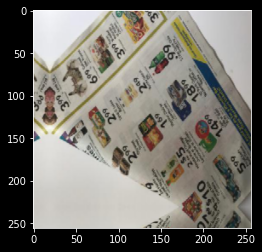

In [ ]:
from tensorflow.python.ops import image_ops
coba = tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
#plt.imshow(image_ops.adjust_contrast(img, 1.2))
hasil = coba(np.array([img]))
plt.imshow(hasil[0])